<font size="+3">Estimation de posture dans une image — Partie 2</font>

_À partir partir d'un TP proposé par Axel Carlier._

---

Pour ce TP ainsi que le suivant, nous allons traiter le problème de la détection du "squelette" d'un humain dans une image, tel qu'illustré dans la figure ci-dessous.

![Texte alternatif…](https://drive.google.com/uc?id=1HpyLwzwkFdyQ6APoGZQJL7f837JCHNkh)

Nous allons pour ce faire utiliser le [Leeds Sport Pose Dataset](https://sam.johnson.io/research/lspet.html) qui introduit 10000 images présentant des sportifs dans diverses situations, augmentées d'une annotation manuelle du squelette.

À chaque image est associée une matrice de taille 3x14, correspondant aux coordonnées dans l'image des 14 joints du squelette de la personne décrite dans l'image. La 3e dimension désigne la visibilité du joint (1 s'il est visible, 0 s'il est occulté)

Ces joints sont, dans l'ordre :
*   Cheville droite
*   Genou droit
*   Hanche droite
*   Hanche gauche
*   Genou gauche
*   Cheville gauche
*   Poignet droit
*   Coude droit
*   Épaule droite
*   Épaule gauche
*   Coude gauche
*   Poignet gauche
*   Cou
*   Sommet du crâne

Pour un rappel des notions vues en cours sur ce sujet, vous pouvez regarder la vidéo ci-dessous :


In [1]:
from IPython.display import IFrame
IFrame("https://video.polymny.studio/?v=84ace9c1-f460-4375-9b33-917c3ff82c83/", width=640, height=360)

# Préliminaires

On utilise la même base de données que pour le Partie 1.

In [2]:
!git clone https://github.com/axelcarlier/lsp.git

fatal: destination path 'lsp' already exists and is not an empty directory.


In [3]:
import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat

# Cette fonction permettra plus tard de charger plus ou moins d'images (en modifiant le paramètre num_images)
# et de modifier la dimension d'entrée

def load_data(image_size=128, num_images=1000):

    path = "./lsp/images/"
    dirs = sorted(os.listdir(path))

    x = np.zeros((min(num_images,len(dirs)),image_size,image_size,3))
    y = np.zeros((min(num_images,len(dirs)), 3, 14))

    #Chargement des joints    
    mat_contents = loadmat('./lsp/joints.mat')
    joints = mat_contents['joints']

    # Chargement des images, qui sont rangées dans lsp/images
    for i in range(min(num_images,len(dirs))):
        item = dirs[i]
        if os.path.isfile(path+item):
            img = Image.open(path+item)
            # Redimensionnement et sauvegarde des joints
            y[i, 0] = joints[:,0,i]*image_size/img.size[0]
            y[i, 1] = joints[:,1,i]*image_size/img.size[1]
            y[i, 2] = joints[:,2,i]
            # Redimensionnement et sauvegarde des images        
            img = img.resize((image_size,image_size))
            x[i] = np.asarray(img)

    return x, y

# Chargement de seulement 10 images, de taille 64x64
x, y = load_data(image_size=64, num_images=10)           
x.shape, y.shape

((10, 64, 64, 3), (10, 3, 14))

In [4]:
labels= {0: 'Cheville droite',
         1: 'Genou droit',
         2: 'Hanche droite',
         3: 'Hanche gauche',
         4: 'Genou gauche',
         5: 'Cheville gauche',
         6: 'Poignet droit',
         7: 'Coude droit',
         8: 'Épaule droite',
         9: 'Épaule gauche',
         10: 'Coude gauche',
         11: 'Poignet gauche',
         12: 'Cou',
         13: 'Sommet du crâne'}

La fonction suivante vous permet de visualiser les données. Vous vous rendrez compte que certaines données sont manquantes ! En effet quand des joints sont occultés dans les images, des valeurs de position aberrantes (négatives) sont indiquées. Dans ce cas, nous n'afficherons pas les articulations.

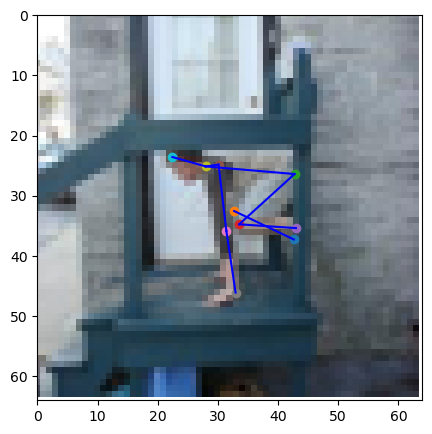

In [5]:
import matplotlib.pyplot as plt

# Fonction d'affichage d'une image et de son label associé
def print_data(x,y,i):

    if y.shape[1] < 3:
        y_new = np.ones((y.shape[0], 3, y.shape[2]))
        y_new[:,0:2,:] = y
        y = y_new

    plt.figure(figsize=(5, 5))
    plt.imshow(x[i]/255)
    for j in range(0,14):
        if y[i, 2, j] == 1:
            plt.scatter(y[i,0,j],y[i,1,j],label=labels.get(j))

    # Jambe droite      
    if (y[i, 2, 0] + y[i, 2, 1] == 2):
        plt.plot(y[i,0,0:2],y[i,1,0:2],'b')
    # Cuisse droite      
    if (y[i, 2, 1] + y[i, 2, 2] == 2):
        plt.plot(y[i,0,1:3],y[i,1,1:3],'b')
    # Bassin     
    if (y[i, 2, 2] + y[i, 2, 3] == 2):
        plt.plot(y[i,0,2:4],y[i,1,2:4],'b')
    # Cuisse gauche      
    if (y[i, 2, 3] + y[i, 2, 4] == 2):
        plt.plot(y[i,0,3:5],y[i,1,3:5],'b')
    # Jambe gauche      
    if (y[i, 2, 4] + y[i, 2, 5] == 2):
        plt.plot(y[i,0,4:6],y[i,1,4:6],'b')
    # Avant-bras droit      
    if (y[i, 2, 6] + y[i, 2, 7] == 2):
        plt.plot(y[i,0,6:8],y[i,1,6:8],'b')
    # Bras droit      
    if (y[i, 2, 7] + y[i, 2, 8] == 2):
        plt.plot(y[i,0,7:9],y[i,1,7:9],'b')
    # Bras gauche     
    if (y[i, 2, 9] + y[i, 2, 10] == 2):
        plt.plot(y[i,0,9:11],y[i,1,9:11],'b')
    # Avant-bras gauche      
    if (y[i, 2, 10] + y[i, 2, 11] == 2):
        plt.plot(y[i,0,10:12],y[i,1,10:12],'b') 
    # Buste droit
    x1=[y[i,0,2],y[i,0,12]]
    y1=[y[i,1,2],y[i,1,12]]
    if (y[i, 2, 2] + y[i, 2, 12] == 2):
        plt.plot(x1, y1,'b')
    # Buste gauche
    x1=[y[i,0,3],y[i,0,12]]
    y1=[y[i,1,3],y[i,1,12]]
    if (y[i, 2, 3] + y[i, 2, 12] == 2):
        plt.plot(x1, y1,'b')
    # Omoplate droite
    x1=[y[i,0,8],y[i,0,12]]
    y1=[y[i,1,8],y[i,1,12]]
    if (y[i, 2, 8] + y[i, 2, 12] == 2):
        plt.plot(x1, y1,'b')
    # Omoplate gauche
    x1=[y[i,0,9],y[i,0,12]]
    y1=[y[i,1,9],y[i,1,12]]
    if (y[i, 2, 9] + y[i, 2, 12] == 2):
        plt.plot(x1, y1,'b')
    # Tete     
    if (y[i, 2, 12] + y[i, 2, 13] == 2):
        plt.plot(y[i,0,12:14],y[i,1,12:14],'b')

    plt.axis([0, x.shape[1], x.shape[2], 0])
    plt.show()
    #plt.legend()

# Affichage aléatoire d'une image
print_data(x,y,np.random.randint(x.shape[0]-1))

Si nous formulons ce problème comme une régression, nous allons utiliser pour évaluer nos réseaux de neurones l'erreur quadratique moyenne (fonction *MSE*). Cette fonction sera parfaite comme fonction de perte, mais elle ne permet pas d'appréhender les résultats de manière satisfaisante.

Une métrique commune en estimation de posture est le **PCK0.5**, pour *Percentage of Correct Keypoints*. *0.5* correspond à un seuil en-deça duquel on considère qu'un joint est correctement estimé. Cette question du seuil est particulièrement sensible car il faut utiliser une valeur qui soit valable pour n'importe quelle image. La personne considérée peut apparaître plus ou moins largement sur l'image, de face ou de profil, ce qui fait qu'une erreur de prédiction sur un joint peut avoir une importance très grande ou très faible selon les cas.

Pour résoudre cette ambiguïté, on considère dans la métrique du **PCK0.5** que la référence est la taille de la tête, définie par la distance entre le joint du cou et le joint de la tête sur la vérité terrain. Un joint prédit par le réseau sera considéré correct s'il est situé à une distance inférieure à la moitié (*0.5*) de la taille de la tête par rapport au joint réel. (**[[Andriluka et al.]](https://openaccess.thecvf.com/content_cvpr_2014/html/Andriluka_2D_Human_Pose_2014_CVPR_paper.html)** _2D Human Pose Estimation: New Benchmark and State of the Art Analysis_)

In [6]:
import numpy.matlib 

# Calcul du "Percentage of Correct Keypoint" avec seuil alpha :
# On compte corrects les joints pour lesquels la distance entre valeurs réelle et prédite 
# est inférieure à alpha fois la dimension de la tête (c'est un peu arbitraire...)
# On ne comptera pas les joints invisibles.
# y_true est de dimension Nx3x14 et y_pred Nx2x14 (le réseau ne prédit pas la visibilité)

def compute_PCK_alpha(y_true, y_pred, alpha=0.5):
    # Calcul des seuils ; la taille de la tête est la distance entre joints 12 et 13
    head_sizes = np.sqrt(np.square(y_true[:,0,13]-y_true[:,0,12])+np.square(y_true[:,1,13]-y_true[:,1,12]))
    thresholds = alpha*head_sizes
    thresholds = np.matlib.repmat(np.expand_dims(thresholds, 1), 1, 14)

    # Calcul des distances inter-joints
    joints_distances = np.sqrt(np.square(y_true[:,0,:]-y_pred[:,0,:]) + np.square(y_true[:,1,:]-y_pred[:,1,:]))

    # Visibilité des joints de la vérité terrain
    visibility = y_true[:,2,:]
    
    total_joints = np.count_nonzero(visibility==1)
    correctly_predicted_joints = np.count_nonzero(np.logical_and(joints_distances<thresholds, visibility == 1))
    
    return correctly_predicted_joints/total_joints

## Petit retour sur la **1ère partie**

Si vous n'êtes pas allés jusqu'au bout de la première partie, sachez que même avec un réseau bien construit, de capacité suffisante, en utilisant les 10000 images de la base d'apprentissage, de la régularisation et de l'augmentation de données (non demandé dans le TP), vous ne seriez pas arrivé à limiter le sur-apprentissage suffisamment pour obtenir des résultats satisfaisants sur l'ensemble de test. On plafonne à un pourcentage de joints correctement prédits (PCK&#64;0.5) aux alentours de 20\%.

Cela est principalement dû à la formulation du problème, plus difficile à résoudre, et aux architectures mises en place. En effet, les couches de sous-échantillonnage (*pooling*) successives entraînent une perte de précision irrémédiable qui ne peut pas être compensée par les couches denses.

# Prédiction de cartes de chaleur

Dans ce TP, nous allons utiliser une autre formulation du problème, présentée pendant le cours. Plutôt que de prédire directement la position pixellique des joints, nous allons prédire des cartes de probabilité de la position des joints, comme illustré ci-dessous. Pour ce faire, il nous faudra tester des architectures de réseau de neurones différentes, s'inspirant de celles utilisées en segmentation d'image.

![Texte alternatif…](https://drive.google.com/uc?id=1B8BCwQ0Szg_T_H05mnfpXFemUT5xhfxX)

## Fonctions utiles

La fonction suivante permet de créer une carte de chaleur de la dimension voulue, avec une gaussienne centrée en un point donné.

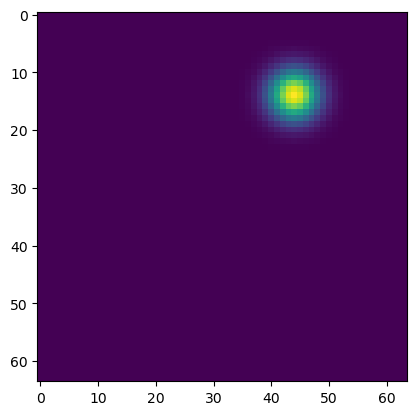

In [7]:
from scipy.ndimage import gaussian_filter

def heat_point(ind_x, ind_y, heatmap_size):
    heat_point=np.zeros((heatmap_size,heatmap_size))
    heat_point[ind_x][ind_y] = 1

    return gaussian_filter(heat_point, round(heatmap_size/20))

h_m = heat_point(14, 44, 64)
plt.imshow(h_m)
plt.show()

On peut ensuite retrouver la position du point le plus "chaud", en utilisant la commande suivante : 

In [8]:
np.unravel_index(np.argmax(h_m), h_m.shape) 

(14, 44)

On peut donc définir les 2 fonctions suivantes permettant de générer les cartes de chaleur à partir des coordonnées de joints, et vice-versa.

### Conversion cartes de chaleurs / coordonnées

In [9]:
def coord2heatmap(y, heatmap_size):
    heatmap = np.zeros((y.shape[0], 14, heatmap_size, heatmap_size))
    for img in range(y.shape[0]):
        for j in range(14):
            ind_x = int(y[img][1][j])
            ind_y = int(y[img][0][j])
            #print(ind_x, ind_y)
            if ind_x >= 0 and ind_y >= 0 and ind_x < heatmap_size and ind_y < heatmap_size:
                heatmap[img][j] = heat_point(ind_x, ind_y, heatmap_size)
    heatmap = np.transpose(heatmap, (0, 2, 3, 1))
    heatmap = heatmap / np.max(heatmap)
    return heatmap


def heatmap2coord(heatmap):
    y = np.ones((heatmap.shape[0], 3, 14))

    heatmap = np.transpose(heatmap, (0, 3, 1, 2))
    for img in range(y.shape[0]):
        for j in range(14): 
            max_heat = np.unravel_index(np.argmax(heatmap[img][j]),heatmap[img][j].shape)  
            y[img][0][j] = max_heat[1]
            y[img][1][j] = max_heat[0]
            if max_heat[0] == 0 and max_heat[1] == 0:
                y[img][2][j] = 0 # Le joint est invisible
    return y

Fonction d'affichage des cartes de chaleur

In [10]:
def print_heatmap(x, y, rows=3):
    hm = np.transpose(y, (0,3,1,2))

    for i in range(rows):
        j = np.random.randint(1,x.shape[0])
        plt.figure(figsize=(12, 12))
        # Affichage de l'image
        plt.subplot(rows,5,5*i+1)
        plt.imshow(x[j])
        plt.title('Image originale')
        # Affichage simultané de tous les joints
        plt.subplot(rows,5,5*i+2)
        joints=np.zeros((y.shape[1], y.shape[2]))
        for k in range(14):
            joints+= hm[j][k]
        plt.imshow(joints)
        plt.title('Tous les joints')

        plt.subplot(rows, 5, 5*i+3)
        plt.imshow(hm[j][13])
        plt.title('Tête')
        plt.subplot(rows, 5, 5*i+4)
        plt.imshow(hm[j][7])
        plt.title('Coude droit')
        plt.subplot(rows, 5, 5*i+5)
        plt.imshow(hm[j][4])
        plt.title('Genou gauche')
        plt.show()

Les lignes suivantes vous permettront de démarrer simplement : 

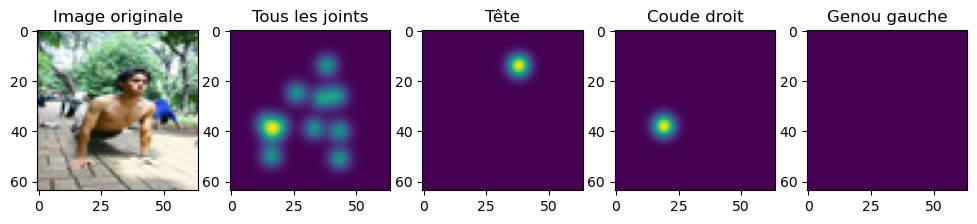

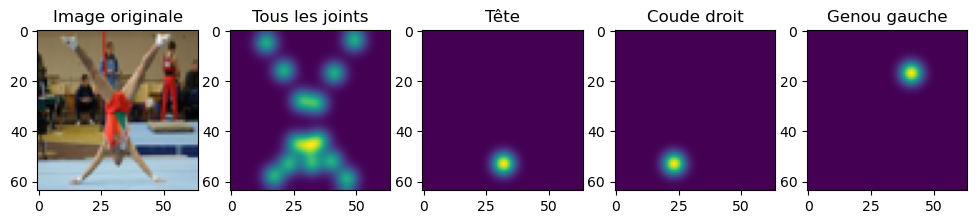

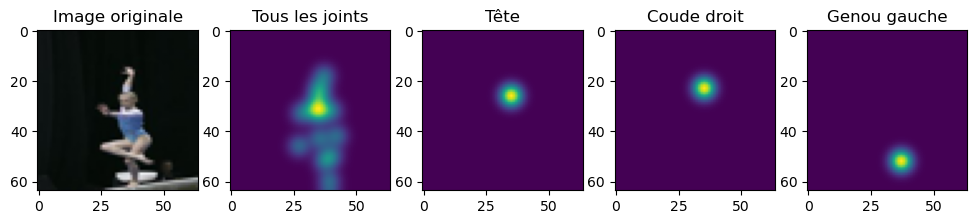

In [11]:
from sklearn.model_selection import train_test_split

# Chargement des données : on choisit une dimension d'image et de carte de chaleur de 64x64
image_size = 64
heatmap_size = 64

# Chargement de seulement 1000 images
x, y = load_data(image_size=image_size, num_images=1000) 

# Normalisation des données
x = x/255

# Chargement des données : 1000 images d'apprentissage, 100 de validation, 100 de test    
x_train, x_gen, y_train, y_gen = train_test_split(x, y, test_size=1/10, random_state=2)
x_val, x_test, y_val, y_test = train_test_split(x_gen, y_gen, test_size=1/2, random_state=1)

# Calcul des cartes de chaleur (prend un peu de temps)
y_hm_train = coord2heatmap(y_train, heatmap_size)
y_hm_val = coord2heatmap(y_val, heatmap_size)
y_hm_test = coord2heatmap(y_test, heatmap_size)

# Affichage de quelques exemples
print_heatmap(x_train, y_hm_train)

### Unet

Pour vous aider pour la suite, voici ci-dessous une implémentation du réseau [UNet](https://fr.wikipedia.org/wiki/U-Net), vu en cours sur la segmentation.

![UNet](http://raw.githubusercontent.com/zhixuhao/unet/master/img/u-net-architecture.png)

A vous de l'adapter afin qu'il soit pertinent pour le problème courant (dimensions d'entrée et de sortie, **fonction d'activation de sortie**)

In [12]:
import tensorflow.keras as keras
from keras.layers import *
from keras import *

def create_unet(image_size=572):
    input_layer = Input((image_size, image_size, 1))

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input_layer, conv10)

    return model

In [13]:
model = create_unet(image_size=64)
model.summary()

2023-03-15 08:32:01.828115: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   640         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

### Affichage

In [14]:
def plot_training_analysis(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

##  Travail à faire 

Essayez d'adapter le réseau Unet à votre problème, puis de l'entraîner sur le petit ensemble de données $x_\text{train}$. 

Plusieurs remarques (**à lire attentivement**) : 



*  Vous devriez observer beaucoup moins de sur-apprentissage ! Si vos prédictions sur l'ensemble de validation sont aberrantes, c'est que vous avez un bug !!
*   Se pose la question de la formulation du problème : dans la mesure où 
les cartes de chaleur sont assimilables à des cartes de probabilité (entre 0 et 1), on peut certes choisir de conserver une formaulation du problème basée sur la régression, mais il est probablement beaucoup plus optimal de formuler le problème comme de la classification binaire.
*   Il y a cependant toujours du sur-apprentissage. Vous pouvez donc augmenter la taille de la base de données à 10000, puis tester différentes possibilités pour diminuer ce sous-apprentissage, notamment l'augmentation de données. Les cellules suivantes vous fournissent des éléments permettant de mettre en place cette augmentation.




## Code fourni pour l'augmentation de données

Je vous fournis ici quelques éléments qui vous permettront de mettre en place de l'augmentation de données. 
Attention l'augmentation rend l'apprentissage plus difficile et en fait plus lent, et vous devrez peut-être augmenter un peu la capacité de votre UNet et le nombre d'epochs pour éviter le sous-apprentissage.

`Albumentation` est une librairie implémentant un grand nombre d'opérations d'augmentation de données. Dans le code suivant, deux types d'augmentation sont définies : des transformations spatiales (`ShiftScaleRotate`), et des transformations colorimétriques. 

In [15]:
import cv2 as cv
from albumentations import (Compose, RandomBrightness, RandomContrast, RandomGamma, ShiftScaleRotate)

AUGMENTATIONS_TRAIN = Compose([
    ShiftScaleRotate(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=0.2, p=0.5)
])

/Users/jchevall/opt/anaconda3/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/Users/jchevall/opt/anaconda3/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


La classe `Sequence` permet de définir l'accès aux données d'entraînement de manière personnalisée, afin par exemple d'implanter des augmentations particulières (c'est le cas ici).


In [16]:
from tensorflow.python.keras.utils.data_utils import Sequence

class LSPDSequence(Sequence):
    # Initialisation de la séquence avec différents paramètres
    def __init__(self, x_set, y_set, batch_size,augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations
        self.indices1 = np.arange(x_set.shape[0]) 
        np.random.shuffle(self.indices1) # Les indices permettent d'accéder
        # aux données et sont randomisés à chaque epoch pour varier la composition
        # des batches au cours de l'entraînement

    # Fonction calculant le nombre de pas de descente du gradient par epoch
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    # Application de l'augmentation de données à chaque image du batch et aux
    # cartes de probabilités associées
    def apply_augmentation(self, bx, by):

        batch_x = np.zeros(bx.shape)
        batch_y = np.zeros(by.shape)
        # Pour chaque image du batch
        for i in range(len(bx)):
            masks = []
            # Les 14 masques associés à l'image sont rangés dans une liste pour 
            # pourvoir être traités par la librairie Albumentation
            for n in range(by.shape[3]):
                masks.append(by[i,:,:,n])

            img = bx[i]
            # Application de l'augmentation à l'image et aux masques
            transformed = self.augment(image=img, masks=masks)
            batch_x[i] = transformed['image']
            batch_y_list = transformed['masks']

            # Reconstitution d'un tenseur à partir des masques augmentés
            for k in range(by.shape[3]):
                batch_y[i,:,:,k] = batch_y_list[k]

        return batch_x, batch_y

    # Fonction appelée à chaque nouveau batch : sélection et augmentation des données
    def __getitem__(self, idx):
        batch_x = self.x[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]
        batch_y = self.y[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]
        
        batch_x, batch_y = self.apply_augmentation(batch_x, batch_y)

        return np.array(batch_x), np.array(batch_y)

    # Fonction appelée à la fin d'un epoch ; on randomise les indices d'accès aux données
    def on_epoch_end(self):
        np.random.shuffle(self.indices1)

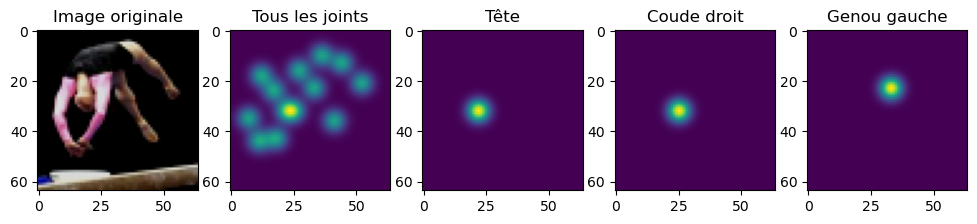

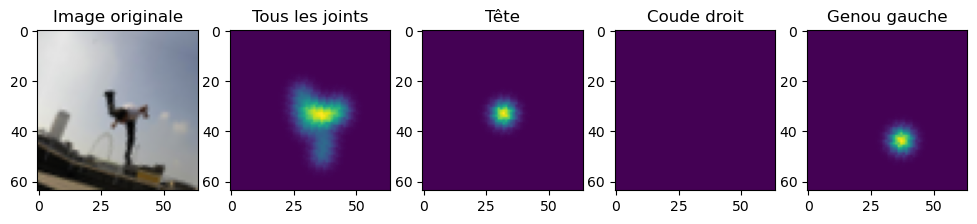

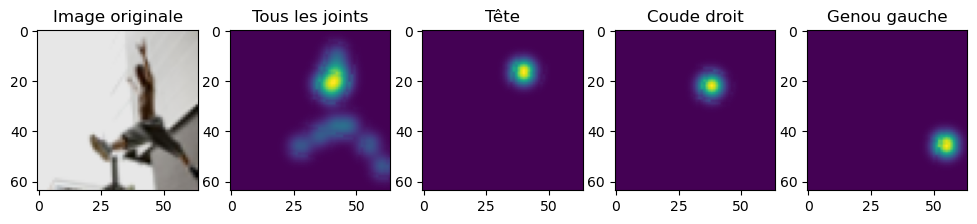

In [17]:
x_train = x_train.astype(np.float32)
y_hm_train = y_hm_train.astype(np.float32)

# Instanciation d'une Sequence
train_gen = LSPDSequence(x_train, y_hm_train, 16, augmentations=AUGMENTATIONS_TRAIN)

# Pour tester la séquence, nous sélectionnons les éléments du premier batch et les affichons
batch_x, batch_y = train_gen.__getitem__(0)

print_heatmap(batch_x, batch_y)

Pour utiliser cette séquence il vous suffit d'appeler la fonction fit de la manière suivante :
```python
model.fit(train_gen, ...)
```

# Correction

In [18]:
import tensorflow.keras as keras
from keras.layers import UpSampling2D, concatenate
from keras import layers
from keras import models
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape, Input, Activation, BatchNormalization, PReLU
from keras.models import Model, Sequential
from keras.initializers import Constant

## Unet Modifié

Le réseau UNet classique prend en entrée des images de taille `(image_size, image_size, 1)`. Or, nous travaillons avec des images en couleur, soit avec 3 canaux. Nous devons donc modifié le réseau UNet pour qu'il puisse traiter de telles données. De plus, en sortie du réseau, on désire trouver 14 cartes de chaleur, une par joint. Il faut donc également modifier également la sortie du UNet original.

On en profite pour simplifier légèrement l'architecture (moins de filtres de convolution dans les différents "étages" du réseau, afin de simplifier l'entraînement.)

In [19]:
def create_unet(image_size=64):
    input_layer=Input((image_size, image_size, 3))

    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(14, 1, activation = 'sigmoid')(conv9)

    model = Model(input_layer, conv10)

    return model

## Version avec 1000 images

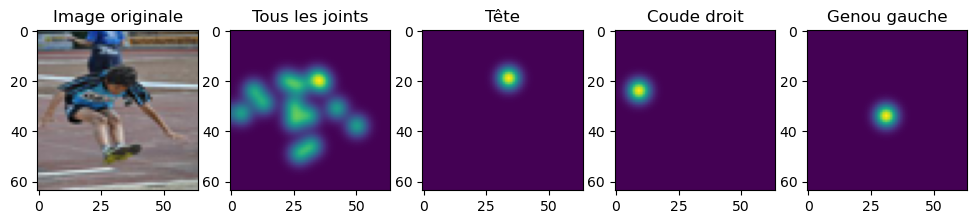

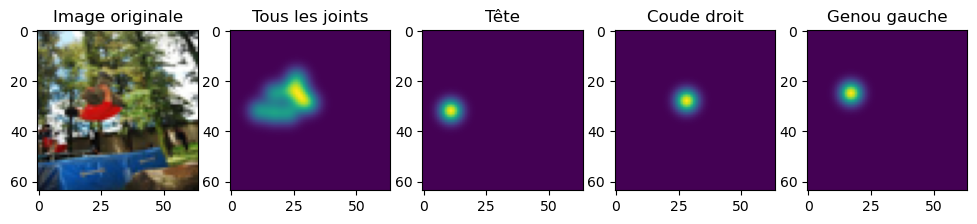

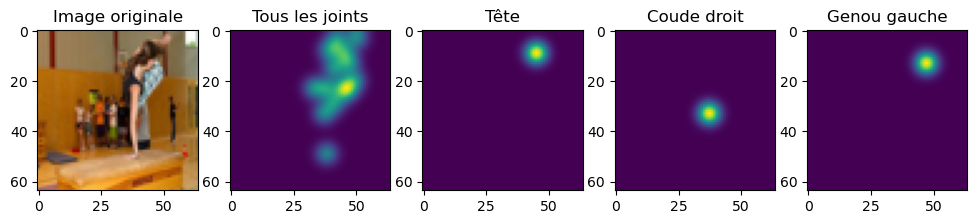

Epoch 1/10
57/57 [==============================] - 36s 610ms/step - loss: 0.0948 - val_loss: 0.0391
Epoch 2/10
57/57 [==============================] - 33s 587ms/step - loss: 0.0199 - val_loss: 0.0375
Epoch 3/10
57/57 [==============================] - 32s 569ms/step - loss: 0.0190 - val_loss: 0.0358
Epoch 4/10
57/57 [==============================] - 33s 573ms/step - loss: 0.0187 - val_loss: 0.0384
Epoch 5/10
57/57 [==============================] - 32s 570ms/step - loss: 0.0186 - val_loss: 0.0353
Epoch 6/10
57/57 [==============================] - 32s 567ms/step - loss: 0.0184 - val_loss: 0.0355
Epoch 7/10
57/57 [==============================] - 32s 564ms/step - loss: 0.0183 - val_loss: 0.0354
Epoch 8/10
57/57 [==============================] - 32s 568ms/step - loss: 0.0181 - val_loss: 0.0357
Epoch 9/10
57/57 [==============================] - 33s 570ms/step - loss: 0.0180 - val_loss: 0.0358
Epoch 10/10
57/57 [==============================] - 32s 569ms/step - loss: 0.0180 - val_lo

In [20]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Chargement des données : on choisit une dimension d'image et de carte de chaleur de 64x64
image_size = 64
heatmap_size = 64

# Chargement de seulement 1000 images
x, y = load_data(image_size=image_size, num_images=1000)  

# Normalisation des données
x = x/255

# Chargement des données : 1000 images d'apprentissage, 50 de validation, 50 de test    
x_train, x_gen, y_train, y_gen = train_test_split(x, y, test_size=1/10, random_state=2)
x_val, x_test, y_val, y_test = train_test_split(x_gen, y_gen, test_size=1/2, random_state=1)

# Calcul des cartes de chaleur (prend un peu de temps)
y_hm_train = coord2heatmap(y_train, heatmap_size)
y_hm_val = coord2heatmap(y_val, heatmap_size)
y_hm_test = coord2heatmap(y_test, heatmap_size)

# Affichage de quelques exemples
print_heatmap(x_train, y_hm_train)


opt = tf.keras.optimizers.Adam(learning_rate=1e-3) 

model = create_unet(image_size=64)
model.compile(loss='binary_crossentropy',
              optimizer=opt)

history = model.fit(x_train, y_hm_train,
          epochs=10,
          batch_size=16,            
          validation_data=(x_val, y_hm_val))

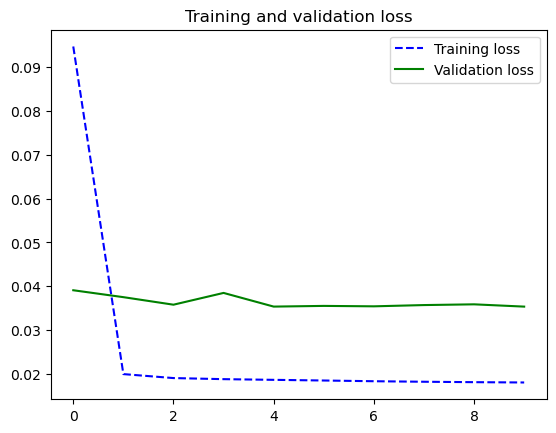

---
Training PCK@0.5 = 0.19427588080789784
Validation PCK@0.5 = 0.21129032258064517
Test PCK@0.5 = 0.1501597444089457
---


In [21]:
plot_training_analysis(history)

# Calcul du PCK
print('---')   
y_hm_pred = model.predict(x_train)
y_pred = heatmap2coord(y_hm_pred)
print('Training PCK@0.5 = ' + str(compute_PCK_alpha(y_train, y_pred, alpha=0.5)))

y_hm_pred = model.predict(x_val)
y_pred = heatmap2coord(y_hm_pred)
print('Validation PCK@0.5 = ' + str(compute_PCK_alpha(y_val, y_pred, alpha=0.5)))

y_hm_pred = model.predict(x_test)
y_pred = heatmap2coord(y_hm_pred)
print('Test PCK@0.5 = ' + str(compute_PCK_alpha(y_test, y_pred, alpha=0.5))) 
print('---')

**Observations** : Le réseau apprend bien en revanche il y a beaucoup de surapprentissage. On obtient des résultats similaires au TP précédent.

## Augmentation de données

Je vous fournis ici quelques éléments qui vous permettront de mettre en place de l'augmentation de données. 
Attention l'augmentation rend l'apprentissage plus difficile, et vous devrez probablement augmenter un peu la capacité de votre UNet pour éviter le sous-apprentissage.


`Albumentation` est une librairie implémentant un grand nombre d'opérations d'augmentation de données. Dans le code suivant, deux types d'augmentation sont définies : des transformations spatiales (`ShiftScaleRotate`), et des transformations colorimétriques. 

In [22]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==1.3.0 is successfully installed


In [23]:
import cv2 as cv
from albumentations import (Compose, RandomBrightnessContrast, RandomGamma, ShiftScaleRotate)

AUGMENTATIONS_TRAIN = Compose([
    ShiftScaleRotate(p=0.5),
    RandomBrightnessContrast(contrast_limit=0.2, brightness_limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
])

La classe `Sequence` permet de définir l'accès aux données d'entraînement de manière personnalisée, afin par exemple d'implanter des augmentations particulières (c'est le cas ici).


In [24]:
from tensorflow.keras.utils import Sequence

class LSPDSequence(Sequence):
    # Initialisation de la séquence avec différents paramètres
    def __init__(self, x_set, y_set, batch_size,augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations
        self.indices1 = np.arange(x_set.shape[0]) 
        np.random.shuffle(self.indices1) # Les indices permettent d'accéder
        # aux données et sont randomisés à chaque epoch pour varier la composition
        # des batches au cours de l'entraînement

    # Fonction calculant le nombre de pas de descente du gradient par epoch
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    # Application de l'augmentation de données à chaque image du batch et aux
    # cartes de probabilités associées
    def apply_augmentation(self, bx, by):

        batch_x = np.zeros(bx.shape)
        batch_y = np.zeros(by.shape)
        # Pour chaque image du batch
        for i in range(len(bx)):
            masks = []
            # Les 14 masques associés à l'image sont rangés dans une liste pour 
            # pourvoir être traités par la librairie Albumentation
            for n in range(by.shape[3]):
                masks.append(by[i,:,:,n])

            img = bx[i]
            # Application de l'augmentation à l'image et aux masques
            transformed = self.augment(image=img, masks=masks)
            batch_x[i] = transformed['image']
            batch_y_list = transformed['masks']

            # Reconstitution d'un tenseur à partir des masques augmentés
            for k in range(by.shape[3]):
                batch_y[i,:,:,k] = batch_y_list[k]

        return batch_x, batch_y

    # Fonction appelée à chaque nouveau batch : sélection et augmentation des données
    def __getitem__(self, idx):
        batch_x = self.x[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]
        batch_y = self.y[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]
        
        batch_x, batch_y = self.apply_augmentation(batch_x, batch_y)

        return np.array(batch_x), np.array(batch_y)

    # Fonction appelée à la fin d'un epoch ; on randomise les indices d'accès aux données
    def on_epoch_end(self):
        np.random.shuffle(self.indices1)

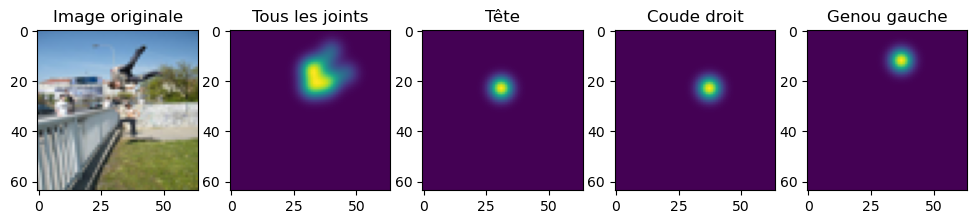

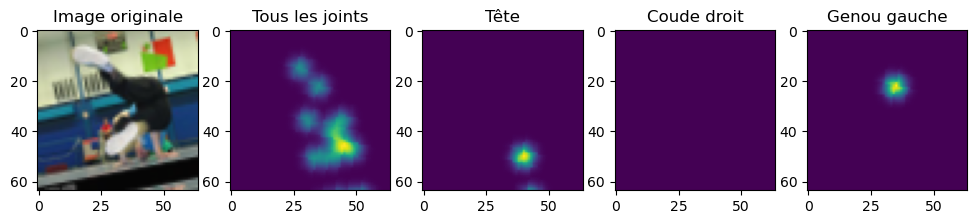

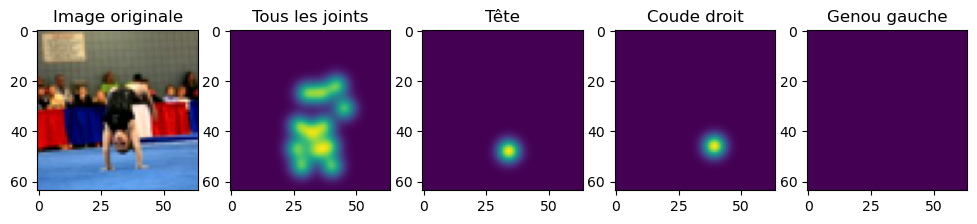

In [25]:
x_train = x_train.astype(np.float32)
y_hm_train = y_hm_train.astype(np.float32)

# Instanciation d'une Sequence
train_gen = LSPDSequence(x_train, y_hm_train, 16, augmentations=AUGMENTATIONS_TRAIN)

# Pour tester la séquence, nous sélectionnons les éléments du premier batch et les affichons
batch_x, batch_y = train_gen.__getitem__(0)

print_heatmap(batch_x, batch_y)

Pour utiliser cette séquence il vous suffit d'appeler la fonction fit de la manière suivante :
```python
model.fit(train_gen, ...)
```

Pour utiliser le package `albumentations`, on a besoin de convertir nos image en `np.float32` (au lieu de 64).

In [26]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Chargement des données : on choisit une dimension d'image et de carte de chaleur de 64x64
image_size = 64
heatmap_size = 64

# Chargement de seulement 1000 images  
x, y = load_data(image_size=image_size, num_images=1000)  

# Normalisation des données
x = x/255
x = x.astype(np.float32)

# Chargement des données : 1000 images d'apprentissage, 50 de validation, 50 de test  
x_train, x_gen, y_train, y_gen = train_test_split(x, y, test_size=1/10, random_state=2)
x_val, x_test, y_val, y_test = train_test_split(x_gen, y_gen, test_size=1/2, random_state=1)

# Calcul des cartes de chaleur (prend un peu de temps)
y_hm_train = coord2heatmap(y_train, heatmap_size)
y_hm_val = coord2heatmap(y_val, heatmap_size)
y_hm_test = coord2heatmap(y_test, heatmap_size)


opt = tf.keras.optimizers.Adam(learning_rate=1e-3) 

model = create_unet(image_size=64)
model.compile(loss='binary_crossentropy',
              optimizer=opt)

train_gen = LSPDSequence(x_train, y_hm_train, 16, augmentations=AUGMENTATIONS_TRAIN)


history = model.fit(train_gen,
          epochs=10,
          batch_size=16,            
          validation_data=(x_val, y_hm_val))

Epoch 1/10
57/57 [==============================] - 34s 573ms/step - loss: 0.0884 - val_loss: 0.0396
Epoch 2/10
57/57 [==============================] - 34s 595ms/step - loss: 0.0206 - val_loss: 0.0367
Epoch 3/10
57/57 [==============================] - 32s 559ms/step - loss: 0.0197 - val_loss: 0.0367
Epoch 4/10
57/57 [==============================] - 33s 573ms/step - loss: 0.0193 - val_loss: 0.0362
Epoch 5/10
57/57 [==============================] - 33s 573ms/step - loss: 0.0192 - val_loss: 0.0358
Epoch 6/10
57/57 [==============================] - 32s 560ms/step - loss: 0.0189 - val_loss: 0.0352
Epoch 7/10
57/57 [==============================] - 32s 560ms/step - loss: 0.0189 - val_loss: 0.0364
Epoch 8/10
57/57 [==============================] - 32s 567ms/step - loss: 0.0189 - val_loss: 0.0351
Epoch 9/10
57/57 [==============================] - 32s 561ms/step - loss: 0.0188 - val_loss: 0.0351
Epoch 10/10
57/57 [==============================] - 32s 559ms/step - loss: 0.0186 - val_lo

Training PCK@0.5 = 0.1861244452495245
Exemples de prédictions sur l'ensemble d'apprentissage


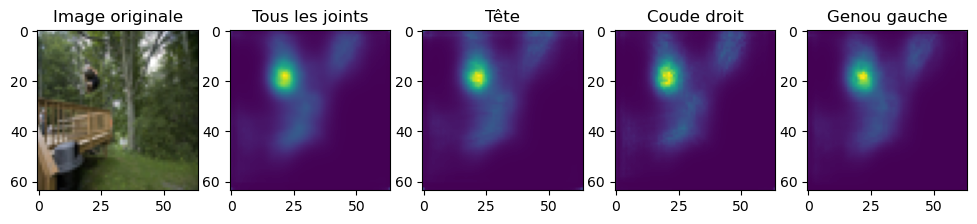

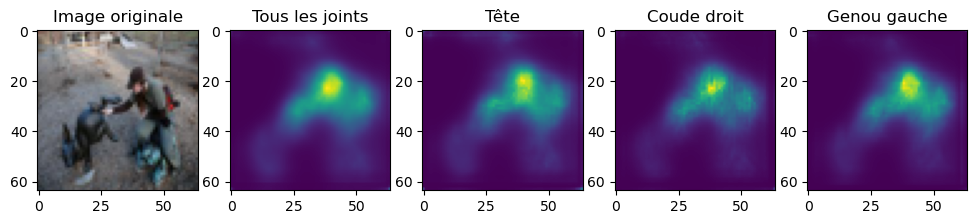

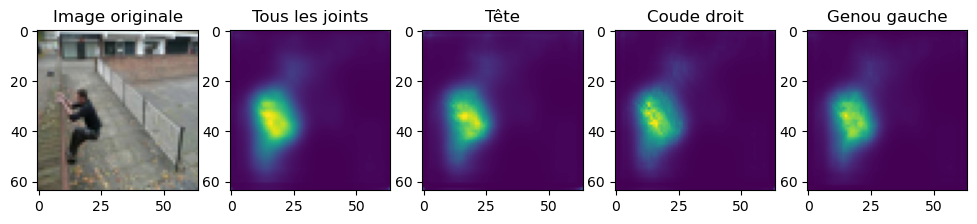


 ------ 

Validation PCK@0.5 = 0.20967741935483872
Exemples de prédictions sur l'ensemble de validation


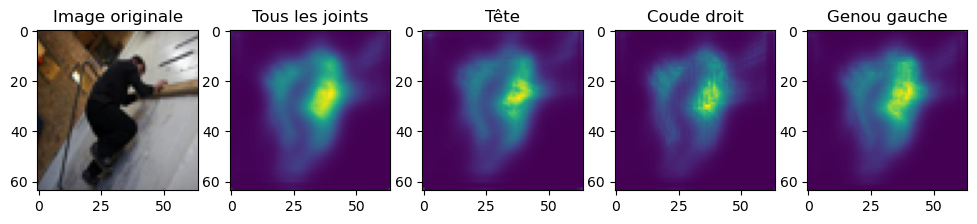

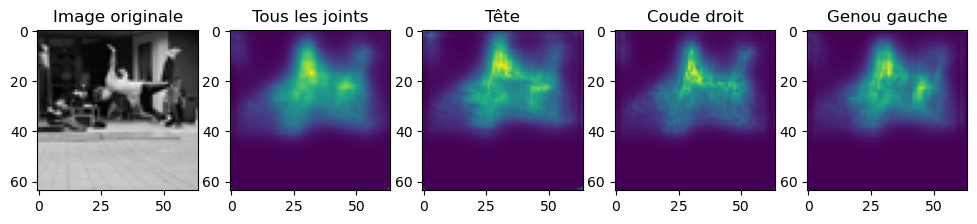

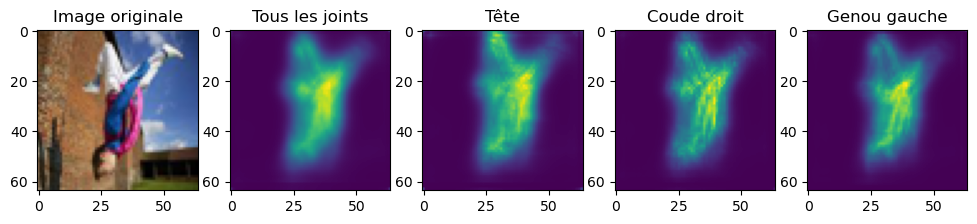


 ------ 

Test PCK@0.5 = 0.1757188498402556
Exemples de prédictions sur l'ensemble de test


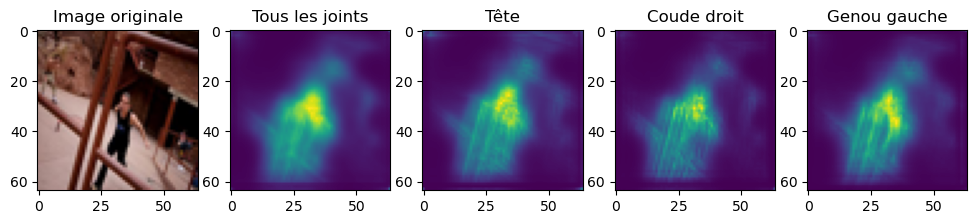

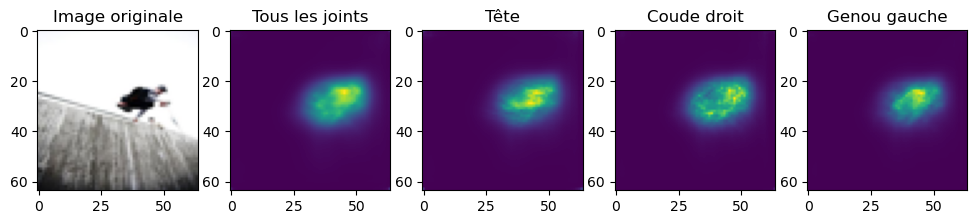

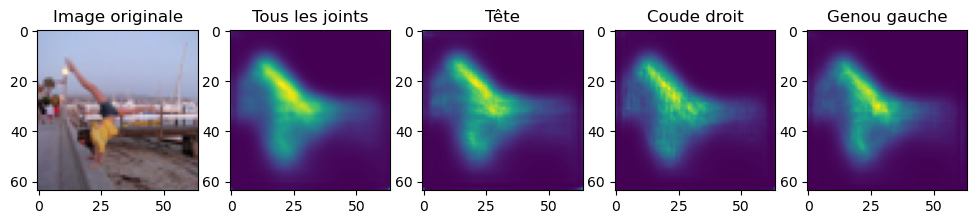

In [27]:
y_hm_pred = model.predict(x_train)
y_pred = heatmap2coord(y_hm_pred)
print('Training PCK@0.5 = ' + str(compute_PCK_alpha(y_train, y_pred, alpha=0.5)))

# Affichage de quelques exemples
print("Exemples de prédictions sur l'ensemble d'apprentissage")
print_heatmap(x_train, y_hm_pred)


print('\n ------ \n')

y_hm_pred = model.predict(x_val)
y_pred = heatmap2coord(y_hm_pred)
print('Validation PCK@0.5 = ' + str(compute_PCK_alpha(y_val, y_pred, alpha=0.5)))

# Affichage de quelques exemples
print("Exemples de prédictions sur l'ensemble de validation")
print_heatmap(x_val, y_hm_pred)


print('\n ------ \n')

y_hm_pred = model.predict(x_test)
y_pred = heatmap2coord(y_hm_pred)
print('Test PCK@0.5 = ' + str(compute_PCK_alpha(y_test, y_pred, alpha=0.5)))  

# Affichage de quelques exemples
print("Exemples de prédictions sur l'ensemble de test")
print_heatmap(x_test, y_hm_pred)

Le sur-apprentissage est moindre, on obtient déjà des résultats meilleurs que dans la première partie (en PCK). On peut observer que les cartes de chaleur prédites sur l'ensemble de test ne sont pas mal du tout.

Seule solution pour vraiment diminuer le sur-apprentissage : utiliser toute la base de données !

## 10000 données, avec augmentation

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Chargement des données : on choisit une dimension d'image et de carte de chaleur de 64x64
image_size = 64
heatmap_size = 64


# Chargement des données : 10000 images d'apprentissage, 500 de validation, 500 de test    
x, y = load_data(image_size=image_size, num_images=10000)  

# Normalisation des données
x = x/255
x = x.astype(np.float32)

x_train, x_gen, y_train, y_gen = train_test_split(x, y, test_size=1/10, random_state=2)
x_val, x_test, y_val, y_test = train_test_split(x_gen, y_gen, test_size=1/2, random_state=1)

# Calcul des cartes de chaleur (prend un peu de temps)
y_hm_train = coord2heatmap(y_train, heatmap_size)
y_hm_val = coord2heatmap(y_val, heatmap_size)
y_hm_test = coord2heatmap(y_test, heatmap_size)


opt = tf.keras.optimizers.Adam(learning_rate=1e-3) 

model = create_unet(image_size=64)
model.compile(loss='binary_crossentropy',
              optimizer=opt)

train_gen = LSPDSequence(x_train, y_hm_train, 16, augmentations=AUGMENTATIONS_TRAIN)


history = model.fit(train_gen,
          epochs=100,
          batch_size=16,            
          validation_data=(x_val, y_hm_val))

In [ ]:
y_hm_pred = model.predict(x_train)
y_pred = heatmap2coord(y_hm_pred)
print('Training PCK@0.5 = ' + str(compute_PCK_alpha(y_train, y_pred, alpha=0.5)))

# Affichage de quelques exemples
print("Exemples de prédictions sur l'ensemble d'apprentissage")
print_heatmap(x_train, y_hm_pred)


print('\n ------ \n')

y_hm_pred = model.predict(x_val)
y_pred = heatmap2coord(y_hm_pred)
print('Validation PCK@0.5 = ' + str(compute_PCK_alpha(y_val, y_pred, alpha=0.5)))

# Affichage de quelques exemples
print("Exemples de prédictions sur l'ensemble de validation")
print_heatmap(x_val, y_hm_pred)


print('\n ------ \n')

y_hm_pred = model.predict(x_test)
y_pred = heatmap2coord(y_hm_pred)
print('Test PCK@0.5 = ' + str(compute_PCK_alpha(y_test, y_pred, alpha=0.5)))  

# Affichage de quelques exemples
print("Exemples de prédictions sur l'ensemble de test")
print_heatmap(x_test, y_hm_pred)

Les résultats sont largement meilleurs ! On a un sous-apprentissage important (PCK d'apprentissage à 50) mais un sur-apprentissage très limité (PCK de test à 40). Pour continuer à progresser il faudrait probablement augmenter un peu la capacité du Unet (plus de filtres) ou faire appel à des réseaux de segmentation plus élaborés.